In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from utilities_namespace import *

In [2]:
from scipy.stats import spearmanr
from seaborn import scatterplot

In [3]:
from data_sources.drug_connectivity_map import DrugConnectivityMap

from signature_scoring import score_signatures
import signature_scoring.scoring_functions.connectivity_score as connectivity

## Validation on CMap v2.0

In [4]:
from config import DATA_DIR
from pathlib import Path

data_path = Path(DATA_DIR)

### Data loading

In [5]:
rank_matrics = read_table(data_path / 'cmap/rankMatrix.txt.zip', index_col=0)

In [6]:
rank_matrics.head()

,1,2,3,4,21,...,7556,7557,7558,7559,Unnamed: 6101
probe_id,,,,,,,,,,,
1007_s_at,6432,12201,5085,7854,2100,...,7063,6620,17845,4489,NaN
1053_at,4817,15753,17671,6825,14301,...,1801,752,1108,873,NaN
117_at,21798,17152,21366,21892,7585,...,12033,12947,8753,10361,NaN
121_at,3435,1669,2628,4541,2834,...,2854,20629,17235,20262,NaN
1255_g_at,7647,2382,4808,13994,13436,...,10398,13352,11639,13511,NaN


In [7]:
rank_matrics.drop('Unnamed: 6101', inplace=True, axis=1)

In [8]:
metadata = pd.read_excel(data_path / 'cmap/cmap_instances_02.xls')

In [9]:
footnotes = metadata[metadata.isna().sum(axis=1) > 1].dropna(how='all').dropna(how='all', axis=1)
footnotes.head()

,instance_id
6101,1 International Nonproprietary Names (INN) for...
6102,2 MCF7: human breast epithelial adenocarcinoma...
6103,PC3: epithelial cell line established from ...
6104,SKMEL5: human malignant melanoma cell line d...
6105,HL60: human promyelocytic cell line establi...


In [10]:
substances = metadata[metadata.isna().sum(axis=1) <= 1].dropna(how='all').set_index('instance_id')
substances.head()

,batch_id,cmap_name,INN1,concentration (M),duration (h),...,scanner,vehicle,vendor,catalog_number,catalog_name
instance_id,,,,,,,,,,,
1,1,metformin,INN,1.000000e-05,6.0,...,HP GeneArray Scanner,medium,Sigma-Aldrich,D5035,"1,1-dimethylbiguanide hydrochloride"
2,1,metformin,INN,1.000000e-05,6.0,...,HP GeneArray Scanner,medium,Sigma-Aldrich,D5035,"1,1-dimethylbiguanide hydrochloride"
3,1,metformin,INN,1.000000e-07,6.0,...,HP GeneArray Scanner,medium,Sigma-Aldrich,D5035,"1,1-dimethylbiguanide hydrochloride"
4,1,metformin,INN,1.000000e-03,6.0,...,HP GeneArray Scanner,medium,Sigma-Aldrich,D5035,"1,1-dimethylbiguanide hydrochloride"
21,2,phenformin,INN,1.000000e-05,6.0,...,HP GeneArray Scanner,medium,Sigma-Aldrich,P7045,phenformin hydrochloride


Meformin, instance id 1 was run via the web interface with cutoff +/- 0.67 (corresponding to fold change of 2). Here are the results:

In [11]:
results_path = data_path / 'cmap/2-fold-change-metformin-1'

In [12]:
metformin_1_tags_up = pd.read_table(results_path / 'multiple instance up', names=['probe_id'])

In [13]:
metformin_1_tags_down = pd.read_table(results_path / 'multiple instance down', names=['probe_id'])

In [14]:
results_metformin_1 = pd.read_excel(results_path / 'detailedResults169452.xls')

Corresponding query is:

In [15]:
metformin_1 = rank_matrics['1']

In [16]:
metformin_1.describe()

count    22283.00000
mean     11142.00000
std       6432.69236
min          1.00000
25%       5571.50000
50%      11142.00000
75%      16712.50000
max      22283.00000
Name: 1, dtype: float64

In [17]:
up_tags = metformin_1.loc[metformin_1_tags_up.probe_id]
down_tags = metformin_1.loc[metformin_1_tags_down.probe_id]

Sanity check: up and down tags should have no intersection:

In [18]:
set(up_tags) & set(down_tags)

set()

### Benchmark setup

In [19]:
from signature_scoring.processor.processor import SignatureProcessor

In [20]:
class CMapProcessor(SignatureProcessor):
    scores_type = dict

In [21]:
from functools import partial

In [22]:
cmap_connectivity = partial(
    connectivity.create_scorer,
    negative=False,
    ranks_type='signature',
    force_custom_tags={
        'up': up_tags,
        'down': down_tags
    }
)

In [23]:
connectivity_score = cmap_connectivity(
    statistic=connectivity.create_kolmogorov_smirnov(
        proper_ks=False, denominator='n-t'
    ),
    compose_tags=connectivity.conditional_difference,
)

connectivity_score_publication = cmap_connectivity(
    statistic=connectivity.kolmogorov_smirnov,
    compose_tags=connectivity.conditional_difference,
)

rges = cmap_connectivity(
    statistic=connectivity.kolmogorov_smirnov,
    compose_tags=connectivity.difference,
)

connectivity_score_weighted_ks = cmap_connectivity(
    statistic=connectivity.create_generalized_kolmogorov_smirnov(p=1),
    compose_tags=connectivity.difference,
)

connectivity_score_cramer = cmap_connectivity(
    statistic=connectivity.cramér_von_mises,
    compose_tags=connectivity.difference,
)

negative=False: substances with similar effect on expression will get high scores
negative=False: substances with similar effect on expression will get high scores
negative=False: substances with similar effect on expression will get high scores
negative=False: substances with similar effect on expression will get high scores
negative=False: substances with similar effect on expression will get high scores


In [24]:
show_source(connectivity_score)

In [25]:
probes_considered = len(rank_matrics)
probes_considered

22283

In [26]:
cs_like_functions = {
    'CS like - Cramér von Mises': connectivity_score_cramer,
    'CS - GSEA KS (p=0)': connectivity_score,
    'CS - as per publication': connectivity_score_publication,
    'CS like - RGES': rges,
    # pharmacoGX does not work for ranks
    # 'CS - pharmacoGX': pharmaco_gx_connectivity_score,
    'CS like - GSEA KS (p=1)': connectivity_score_weighted_ks,
}

functions_results = {}

### Benchmark

In [27]:
for name, function in tqdm(cs_like_functions.items()):
    scores = score_signatures(
        function, metformin_1, signatures=rank_matrics,
        progress=False, processor_type=CMapProcessor,
        limit=probes_considered,
        processes=8
    )
    scores = Series(scores)
    scores.name = 'score'
    functions_results[name] = scores

Retaining 22283 genes: 100.00% of signature genes and 100.00% of query genes
Selected only 22283 genes out of 44566 allowed.
Retaining 22283 genes: 100.00% of signature genes and 100.00% of query genes
Selected only 22283 genes out of 44566 allowed.
Retaining 22283 genes: 100.00% of signature genes and 100.00% of query genes
Selected only 22283 genes out of 44566 allowed.
Retaining 22283 genes: 100.00% of signature genes and 100.00% of query genes
Selected only 22283 genes out of 44566 allowed.
Retaining 22283 genes: 100.00% of signature genes and 100.00% of query genes
Selected only 22283 genes out of 44566 allowed.



#### Results scaling

CMap scores are re-scaled to +/-1 with the following function:

In [28]:
def scale_scores(scores):
    mi = min(scores)
    ma = max(scores)
    return scores.apply(lambda s_i: s_i/ma if s_i > 0 else -s_i/mi)

In [29]:
DataFrame(functions_results)

,CS like - Cramér von Mises,CS - GSEA KS (p=0),CS - as per publication,CS like - RGES,CS like - GSEA KS (p=1)
1,-2.739032e+06,1.988637,1.978908,1.978908,2.000000
1000,-2.760075e+06,0.157665,0.160783,0.160783,0.008368
1001,-2.760450e+06,0.189309,0.188798,0.188798,0.041465
1002,-2.761258e+06,0.000000,0.166994,0.166994,-0.026407
1003,-2.761220e+06,0.000000,0.000000,0.041030,-0.033778
...,...,...,...,...,...
995,-2.762176e+06,0.000000,0.000000,-0.001821,-0.040446
996,-2.757784e+06,0.000000,0.000000,0.053832,-0.034247
997,-2.759421e+06,0.234441,0.232547,0.232547,0.091563
998,-2.759771e+06,0.154828,0.154893,0.154893,0.008138


In [30]:
functions_results = {
    name: scale_scores(scores)
    for name, scores in functions_results.items()
}

In addition, Cramér von Mises modification required mean centering (as for ranks - which are always positive - it produces only negative values):

In [31]:
cvm = functions_results['CS like - Cramér von Mises']

In [32]:
functions_results['CS like - Cramér von Mises'] = scale_scores(cvm - cvm.mean())

### Results

In [33]:
cmap_v2_0_scores = results_metformin_1.set_index('instance_id').score

In [34]:
from sklearn.metrics import r2_score
from helpers import first

def compare_with_reference(functions_results, reference_scores, reference_name):
    reference_scores.index = reference_scores.index.astype(str)
    functions_results = {reference_name: reference_scores, **functions_results}

    stats = {
        function_name: {
            name: stat(scores, reference_scores.loc[scores.index])
            for name, stat in [('r2', r2_score), ('spearman', spearmanr)]
        }
        for function_name, scores in functions_results.items()
    }
    
    data = concat([
        scores.to_frame().assign(
            type=name,
            spearman=(
                f'$\\rho$ = {stats[name]["spearman"].correlation:.2f}, '
                f'p = {stats[name]["spearman"].pvalue:.2e}'
            ),
            r2='$R^{2}$ = ' + f"${stats[name]['r2']:.2f}$"
        )
        for name, scores in functions_results.items()
    ])

    data = data.reset_index().rename(
        {'index': 'instance_id'}, axis=1
    ).sort_values(['type', 'score'])

    # workaround for rpy2 issues
    data.to_csv('temp', index=False)
    data = pd.read_csv('temp')

    data.instance_id = data.instance_id.astype(str)
    data.instance_id = pd.Categorical(
        data.instance_id,
        ordered=True,
        categories=reference_scores.sort_values().index.astype(str)
    )
    return data

In [35]:
data = compare_with_reference(functions_results, cmap_v2_0_scores, 'CMap 2.0')
annotations = data[['r2', 'spearman', 'type']].drop_duplicates()

In [36]:
%%capture
%load_ext rpy2.ipython
%R require(ggplot2)
%R require(latex2exp)

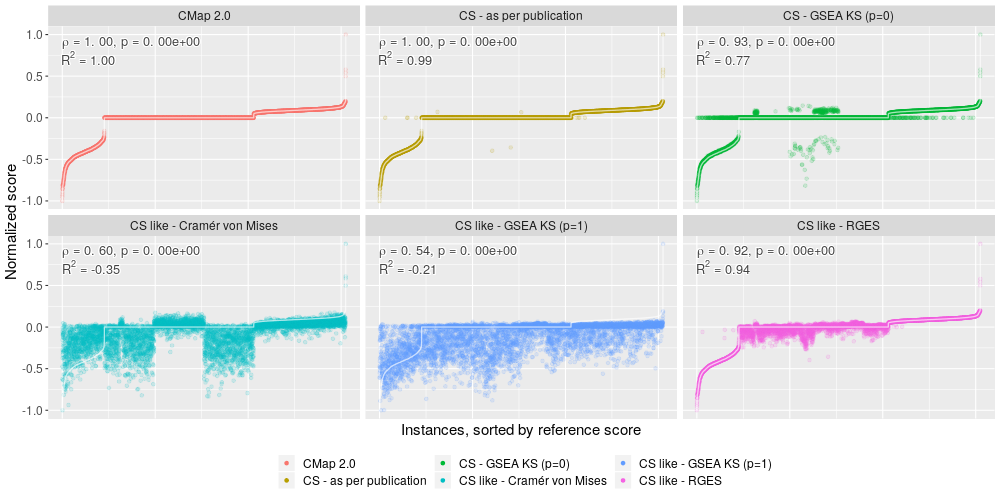

In [37]:
%%R -i data -w 1000 -i annotations -h 500
annotations$r2 = lapply(annotations$r2, TeX, 'character')
annotations$spearman = lapply(annotations$spearman, TeX, 'character')
g = (
    ggplot(data, aes(y=score, x=as.numeric(instance_id), color=type))
    + facet_wrap(type ~ .)
    + geom_point(alpha=0.15)
    + geom_line(
        data=data[data$type == 'CMap 2.0', c('instance_id', 'score')],
        color='white', alpha=0.65, size=0.6
    )
    + shadowtext::geom_shadowtext(
        data=annotations, aes(x=-Inf, y=0.90, label=spearman),
        hjust=-0.1, parse=T, size=4.5, show.legend=F, bg.r=0.1, bg.colour='white',
        color='#444444'
    )
    + shadowtext::geom_shadowtext(
        data=annotations, aes(x=-Inf, y=0.72, label=r2),
        hjust=-0.24, parse=T, size=4.5, show.legend=F, bg.r=0.1, bg.colour='white',
        color='#444444'
    )
    + theme(
        axis.text.x = element_blank(),
        axis.ticks.x=element_blank(),
        legend.position='bottom',
        legend.box='horizontal',
        text=element_text(size=15)
    )
    + xlab('Instances, sorted by reference score')
    + ylab('Normalized score')
    + guides(
        color=guide_legend(
            override.aes=list(alpha=1),
            title=''
        )
    )
)
ggsave(file="connectivity_score_correlation_validation.svg", plot=g, width=14, height=7)
ggsave(file="connectivity_score_correlation_validation.png", plot=g, width=14, height=7)
g

In [38]:
data.to_csv('connectivity_score_correlation_validation.csv')

One can notice that RGES seem to correlate with Cramer von Mises (both use unconditional difference, without the nullification term), though the same is not obvious for weighted GSEA. Let's investigate:

In [39]:
analyzed_functions = [
    'CS like - RGES',
    'CS like - Cramér von Mises',
    'CS like - GSEA KS (p=1)'
]
subset = copy(data[data.type.isin(analyzed_functions)])
annotations_subset = annotations[annotations.type.isin(analyzed_functions)]

In [40]:
rges_sorted = (
    subset[subset.type == 'CS like - RGES']
    .set_index('instance_id')
    .score
    .sort_values()
)

In [41]:
subset.instance_id = pd.Categorical(
    subset.instance_id,
    ordered=True,
    categories=list(rges_sorted.index)
)

In [42]:
subset.head()

,instance_id,score,type,spearman,r2
18300,407,-1.000000,CS like - Cramér von Mises,"$\rho$ = 0.60, p = 0.00e+00",$R^{2}$ = $-0.35$
18301,1928,-0.937200,CS like - Cramér von Mises,"$\rho$ = 0.60, p = 0.00e+00",$R^{2}$ = $-0.35$
18302,6654,-0.834730,CS like - Cramér von Mises,"$\rho$ = 0.60, p = 0.00e+00",$R^{2}$ = $-0.35$
18303,7060,-0.830979,CS like - Cramér von Mises,"$\rho$ = 0.60, p = 0.00e+00",$R^{2}$ = $-0.35$
18304,1562,-0.820953,CS like - Cramér von Mises,"$\rho$ = 0.60, p = 0.00e+00",$R^{2}$ = $-0.35$


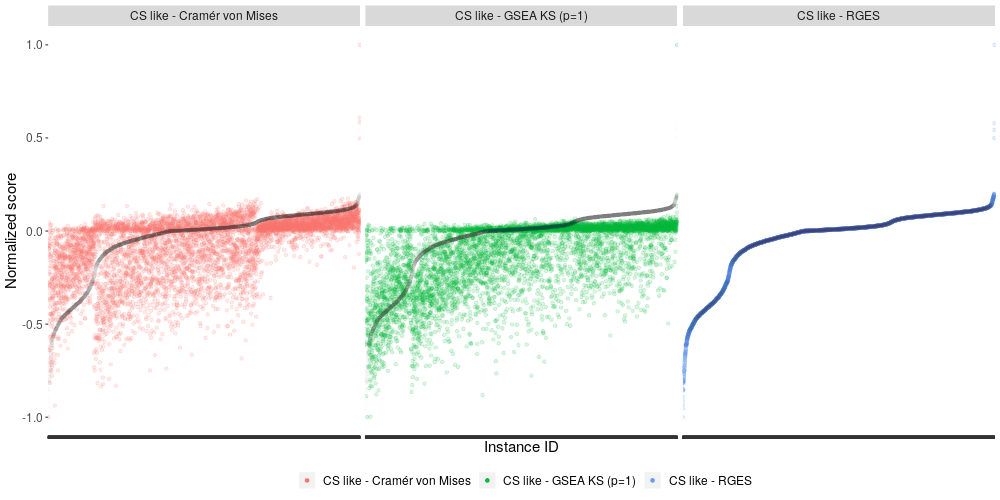

In [43]:
%%R -i subset -w 1000 -i annotations_subset -h 500
annotations_subset$r2 = lapply(annotations_subset$r2, TeX, 'character')
g = (
    ggplot(subset, aes(y=score, x=instance_id, color=type))
    + facet_wrap(type ~ .)
    + geom_point(alpha=0.15)
    + geom_point(data=subset[subset$type == 'CS like - RGES', c('instance_id', 'score')], color='black', alpha=0.0065)
    + theme(axis.text.x=element_blank(), legend.position='bottom', legend.box='horizontal', text=element_text(size=15))
    + xlab('Instance ID')
    + ylab('Normalized score')
    + guides(
        color=guide_legend(
            override.aes=list(alpha=1),
            title=''
        ))
)
g

Well, it's not that obvious any longer...

## Validation on LINCS

Below I demonstrate that my implementation of ConnectivityScore performs similarly to the original one, comparing my results with results retrieved from the Connectopedia (an official resource developed by LINCS, clue.io)

I will investigate connectivity score between *vemurafenib* and *JNK inhibitors* (an example presented on the homepge of the clue.io):

https://clue.io/command?q=/conn%20vemurafenib%20%22JNK%20inhibitor%22

For simplicity, I will select one cell line (VCAP) and restric scores calulation to the perturbagene itself (vemurafenib-CP).

Below is a screenshot with the result retrieved from clue.io:

<img src="../images/connectivity_map_query.png">
<img src="../images/connectivity_map_compounds.png">

I identify *vemurafenib* signature:

In [44]:
dcm = DrugConnectivityMap()

In [45]:
query_df = dcm.from_perturbations(['vemurafenib'], cell_id='VCAP')
assert len(query_df.columns) == 1
query = query_df['CPC006_VCAP_24H:BRD-K56343971-001-02-3:10']

Got perturbations for 1/1 or 100.00% of substances. 


I download the gct file using "Export as" button and load it:

In [46]:
results_matrix = read_table(
    data_path / 'cmap/clue.io/vemurafenib-VCAP-with_itself-JNK inhibitor.gct',
    skiprows=2,
    header=list(range(26)),
    index_col=[0]
)

It turns out that we get scores for multiple instances of vemurafenib:
- BRD-A60245366-VCAP
- BRD-K73982490-VCAP
- BRD-K84085265-VCAP
- BRD-K19220233-VCAP
- BRD-K01567962-VCAP
- BRD-K56343971-VCAP
- BRD-U51951544-VCAP

In [47]:
show_table(results_matrix, n_rows=10, n_cols=100)

id,type,name,description,target,belongs_to,group_by,score,BRD-A60245366-VCAP,BRD-K73982490-VCAP,BRD-K84085265-VCAP,BRD-K19220233-VCAP,BRD-K01567962-VCAP,BRD-K56343971-VCAP,BRD-U51951544-VCAP
cell_id,na,na,na,na,na,na,na,VCAP,VCAP,VCAP,VCAP,VCAP,VCAP,VCAP
_id,na,na,na,na,na,na,na,BRD-A60245366,BRD-K73982490,BRD-K84085265,BRD-K19220233,BRD-K01567962,BRD-K56343971,BRD-U51951544
name,na,na,na,na,na,na,na,AS-601245,BI-78D3,CG-930,JNK-9L,pyrazolanthrone,vemurafenib,ZG-10
pert_type,na,na,na,na,na,na,na,trt_cp,trt_cp,trt_cp,trt_cp,trt_cp,trt_cp,trt_cp
moiety,na,na,na,na,na,na,na,AS-601245,BI-78D3,CG-930,JNK-9L,pyrazolanthrone,vemurafenib,ZG-10
moa,na,na,na,na,na,na,na,JNK inhibitor,JNK inhibitor,JNK inhibitor,JNK inhibitor,JNK inhibitor,RAF inhibitor,JNK inhibitor
gene_targets,na,na,na,na,na,na,na,MAPK10|MAPK8|MAPK9,MAPK8,MAPK8,MAPK8,MAPK10|MAPK8|MAPK9|TTK,BRAF,IRAK1
gene_ids,na,na,na,na,na,na,na,5602|5599|5601,5599,5599,5599,5602|5599|5601|7272,673,3654
inchikey,na,na,na,na,na,na,na,RCYPVQCPYKNSTG-UHFFFAOYSA-N,QFRLDZGQEZCCJZ-UHFFFAOYSA-N,IBGLGMOPHJQDJB-MCIONIFRSA-N,AHMHIFXJPSHHPH-UHFFFAOYSA-N,ACPOUJIDANTYHO-UHFFFAOYSA-N,GPXBXXGIAQBQNI-UHFFFAOYSA-N,-666
smiles,na,na,na,na,na,na,na,N#CC(c1nc2ccccc2s1)c1ccnc(NCCc2cccnc2)n1,Oc1nnc(Sc2ncc(s2)[N+]([O-])=O)n1-c1ccc2OCCOc2c1,O[C@H]1CC[C@H](CC1)Nc1ncc2nc(Nc3c(F)cc(F)cc3F)n([C@@H]3CCOC3)c2n1,Fc1cc(cc(c1)-c1ccnc(Nc2ccc(cc2)-n2cnc(n2)N2CCOCC2)n1)N1CCOCC1,O=C1c2ccccc2-c2n[nH]c3cccc1c23,CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(cc23)-c2ccc(Cl)cc2)c1F,-666


But the *score* column is actually identical with the scores for *BRD-K56343971*:

In [48]:
def result_colum(kind, value, as_series=True, keep_columns=False):
    column = results_matrix.loc[:,results_matrix.columns.get_level_values(kind) == value]
    if not keep_columns:
        column.columns = [value]
    if as_series:
        return column[value]
    return column

In [49]:
(result_colum('id', 'score') == result_colum('id', 'BRD-K56343971-VCAP')).all()

True

Lets find out:

In [50]:
reference_scores = result_colum('id', 'score', False)
reference_scores

,score
BRD-K56343971,99.97
BRD-K95901403,99.94
CGS001-440,99.94
ccsbBroad304_07288,99.89
CGS001-1906,99.88
...,...
ccsbBroad304_06081,-98.72
ccsbBroad304_06453,-98.94
BRD-K16554956,-98.97
ccsbBroad304_09354,-99.44


In [51]:
perturbations = reference_scores.index

In [52]:
len(perturbations)

50

In [53]:
signature_ids = dcm.ids_for_perturbations(perturbations, pert_id=True, exemplar_only=False)

In [54]:
len(signature_ids)

1029

In [55]:
tested_substances = dcm.from_ids(signature_ids, cell_id='VCAP', exemplar_only=False)

In [56]:
tested_substances

,CPC004_VCAP_6H:BRD-A94756469-001-03-9:10,CPC004_VCAP_6H:BRD-K38305202-001-08-3:10,CPC003_VCAP_6H:BRD-K23566484-001-09-4:10,CPC003_VCAP_6H:BRD-K88625236-001-03-4:10,CPC002_VCAP_6H:BRD-K16195444-003-13-8:10,...,CGS001_VCAP_120H:SETDB1:5,CGS001_VCAP_120H:SPTAN1:5,CGS001_VCAP_120H:STK38L:5,CGS001_VCAP_120H:UIMC1:5,CGS001_VCAP_168H:CDK11B:5
b'5720',-0.131537,-0.531899,0.257538,0.009786,0.522439,...,-0.527352,-0.010758,0.030943,0.310602,-0.448963
b'466',-0.034627,-1.346397,-0.314064,-0.576993,1.321260,...,-0.198698,-0.530095,0.578626,-0.996062,0.140354
b'6009',-1.723624,-0.436859,-0.480005,-0.502279,0.101070,...,-0.471340,0.482158,-0.288226,-0.154791,0.988375
b'2309',-0.819967,0.611341,-0.551205,0.071536,-1.395564,...,0.587324,0.613030,-0.721403,1.000592,0.312527
b'387',-0.824172,0.692681,-0.331333,-0.651974,-0.129842,...,0.486068,1.154006,-0.252037,0.600547,0.415043
...,...,...,...,...,...,...,...,...,...,...,...
b'25960',0.112473,-0.285003,0.438583,0.399846,-0.418055,...,0.042659,-0.799853,-0.526452,-0.789460,0.205041
b'6376',0.362229,1.999210,0.300829,0.641212,0.096206,...,0.129747,-0.064019,0.095501,-0.044565,0.382512
b'11033',-0.491799,0.084092,-0.520228,0.732344,-1.343936,...,-0.890623,-0.274022,-0.076941,-0.232358,0.295911
b'54869',-0.146252,2.150512,0.649893,0.669383,-1.536411,...,-0.422884,-0.288335,-0.548188,-0.324490,-0.428437


In [57]:
pert_found = set(dcm.sig_info[dcm.sig_info.sig_id.isin(tested_substances)].pert_id)
len(pert_found)

40

In [58]:
pert_in_result = set(perturbations)
len(pert_in_result)

50

In [59]:
common_pert = pert_in_result & pert_found
len(common_pert)

40

### Scoring

In [60]:
lincs_connectivity = partial(
    connectivity.create_scorer,
    negative=False,
    ranks_type='signature'
)

In [61]:
connectivity_score = lincs_connectivity(
    statistic=connectivity.create_kolmogorov_smirnov(
        proper_ks=False, denominator='n-t'
    ),
    compose_tags=connectivity.conditional_difference
)

connectivity_score_publication = lincs_connectivity(
    statistic=connectivity.kolmogorov_smirnov,
    compose_tags=connectivity.conditional_difference
)

rges = lincs_connectivity(
    statistic=connectivity.kolmogorov_smirnov,
    compose_tags=connectivity.difference
)

connectivity_score_weighted_ks = lincs_connectivity(
    statistic=connectivity.create_generalized_kolmogorov_smirnov(p=1),
    compose_tags=connectivity.difference
)

connectivity_score_cramer = lincs_connectivity(
    statistic=connectivity.cramér_von_mises,
    compose_tags=connectivity.difference
)

negative=False: substances with similar effect on expression will get high scores
negative=False: substances with similar effect on expression will get high scores
negative=False: substances with similar effect on expression will get high scores
negative=False: substances with similar effect on expression will get high scores
negative=False: substances with similar effect on expression will get high scores


In [62]:
from signature_scoring.scoring_functions.generic_scorers import x_cos, x_product, x_sum
from signature_scoring.scoring_functions.connectivity_score import pharmaco_gx_connectivity_score

In [63]:
cs_like_functions = {
    'CS like - Cramér von Mises': connectivity_score_cramer,
    'CS - GSEA KS (p=0)': connectivity_score,
    'CS - as per publication': connectivity_score_publication,
    'CS like - RGES': rges,
    'CS - pharmacoGX': pharmaco_gx_connectivity_score,
    'CS like - GSEA KS (p=1)': connectivity_score_weighted_ks,
    'XSum': x_sum,
    'XCos': x_cos,
    'XProduct': x_product
}

lincs_results = {}

for name, function in tqdm(cs_like_functions.items()):
    scores = score_signatures(
        function, query, signatures=tested_substances,
        progress=False, processes=8,
        # some scoring functions (like KS with /(n-t) do not work well
        # with unlimited tags;  they also do not work with limits which
        # are applied to both profiles (disease and drug) -
        # so they need to have a limi for drug profile (here 500)
        # but not for he disease one:
        limit=500, limit_genes=False
    )
    scores = scores.aggregate('pert_id', 'mean').score
    scores.name = 'score'
    lincs_results[name] = scores

Retaining 12328 genes: 100.00% of signature genes and 100.00% of query genes
Selected only 12328 genes out of 1000 allowed.
Retaining 12328 genes: 100.00% of signature genes and 100.00% of query genes
Selected only 12328 genes out of 1000 allowed.
Retaining 12328 genes: 100.00% of signature genes and 100.00% of query genes
Selected only 12328 genes out of 1000 allowed.
Retaining 12328 genes: 100.00% of signature genes and 100.00% of query genes
Selected only 12328 genes out of 1000 allowed.
Retaining 12328 genes: 100.00% of signature genes and 100.00% of query genes
Selected only 12328 genes out of 1000 allowed.
Retaining 12328 genes: 100.00% of signature genes and 100.00% of query genes
Selected only 12328 genes out of 1000 allowed.
Retaining 12328 genes: 100.00% of signature genes and 100.00% of query genes
Selected only 12328 genes out of 1000 allowed.
Retaining 12328 genes: 100.00% of signature genes and 100.00% of query genes
Selected only 12328 genes out of 1000 allowed.
Retainin

In [64]:
lincs_results = {
    name: scale_scores(scores - scores.mean()) * 100
    for name, scores in lincs_results.items()
}

In [65]:
DataFrame(lincs_results)

,CS like - Cramér von Mises,CS - GSEA KS (p=0),CS - as per publication,CS like - RGES,CS - pharmacoGX,CS like - GSEA KS (p=1),XSum,XCos,XProduct
BRD-A25775766,49.138528,-48.950132,-50.475368,-47.588806,64.000787,-40.350041,46.751994,54.582856,53.205980
BRD-A45889380,36.116699,-47.037051,-47.290024,-47.318629,33.016880,-22.405359,47.320901,54.331350,47.581191
BRD-A64297288,55.076765,-60.719902,-60.584812,-60.606202,57.922348,-40.570453,52.916693,80.623248,60.851007
BRD-A77299732,-15.496662,10.696678,7.821281,7.765959,-11.735861,7.919503,-10.154095,-31.267939,-10.640668
BRD-A94756469,53.558633,-56.896292,-58.184350,-58.207042,62.173186,-42.767934,43.685543,79.696444,50.955756
...,...,...,...,...,...,...,...,...,...
ccsbBroad304_06453,38.518230,-48.905369,-49.754104,-49.781372,47.380410,-45.661236,29.654919,69.315786,31.803942
ccsbBroad304_06481,-29.597907,-5.299325,30.016572,29.974570,-23.838894,10.194962,-10.153046,-7.807261,-5.545574
ccsbBroad304_07006,67.034209,-68.667960,-68.620855,-68.637884,67.699088,-52.705374,52.901418,98.654377,54.748255
ccsbBroad304_07288,-24.827672,27.971656,24.442941,24.397594,-31.332574,12.288119,-22.714915,-48.038122,-22.947813


In [66]:
to_flip = ['XProduct', 'XCos', 'XSum', 'CS - pharmacoGX', 'CS like - Cramér von Mises']
for key in to_flip:
    lincs_results[key] = -lincs_results[key]

In [67]:
data_lincs = compare_with_reference(
    lincs_results,
    reference_scores[reference_scores.index.isin(common_pert)].score,
    'LINCS CMap'
)
data_lincs.type = pd.Categorical(
    data_lincs.type, ordered=True,
    categories=['LINCS CMap', *cs_like_functions]
)
annotations_lincs = data_lincs[['r2', 'spearman', 'type']].drop_duplicates()

In [68]:
data_lincs.to_csv('connectivity_score_lincs_correlation_validation.csv')

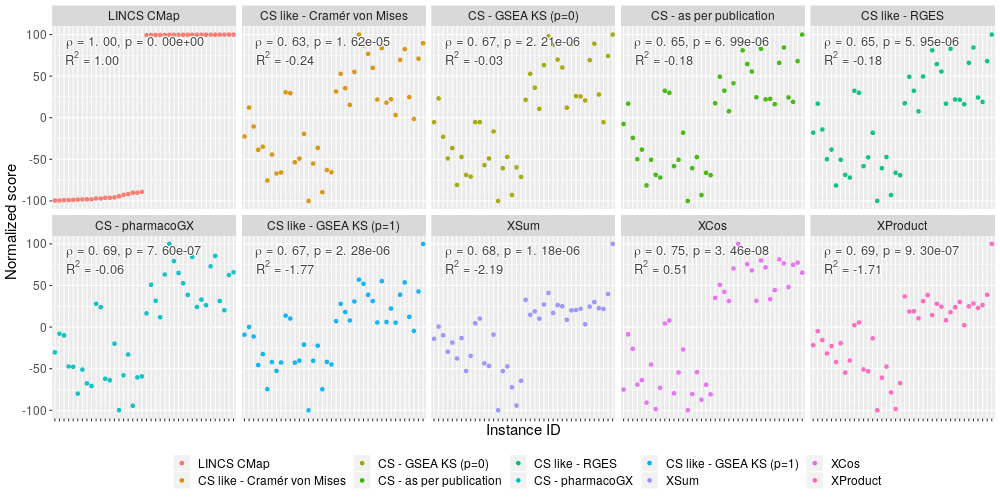

In [69]:
%%R -i data_lincs -w 1000 -i annotations_lincs -h 500
annotations_lincs$spearman = lapply(annotations_lincs$spearman, TeX, 'character')
annotations_lincs$r2 = lapply(annotations_lincs$r2, TeX, 'character')
g = (
    ggplot(data_lincs, aes(y=score, x=instance_id, color=type))
    + facet_wrap(type ~ ., ncol=5)
    + geom_point(alpha=0.9)
    + geom_point(data=data_lincs[data_lincs$type == 'LINCS CMap', c('instance_id', 'score')], color='black', alpha=0.0065)
    + shadowtext::geom_shadowtext(
        data=annotations_lincs, aes(x=-Inf, y=90, label=spearman),
        hjust=-0.1, parse=T, size=4.5, show.legend=F, bg.r=0.1, bg.colour='white',
        color='#444444'
    )
    + shadowtext::geom_shadowtext(
        data=annotations_lincs, aes(x=-Inf, y=72, label=r2),
        hjust=-0.24, parse=T, size=4.5, show.legend=F, bg.r=0.1, bg.colour='white',
        color='#444444'
    )
    + theme(axis.text.x = element_blank(), legend.position='bottom', legend.box='horizontal', text=element_text(size=15))
    + xlab('Instance ID')
    + ylab('Normalized score')
    + guides(
        color=guide_legend(
            override.aes=list(alpha=1),
            title=''
        )
    )
    + scale_color_discrete()
)
ggsave(file="connectivity_score_lincs_correlation_validation.svg", plot=g, width=15, height=7.5)
ggsave(file="connectivity_score_lincs_correlation_validation.png", plot=g, width=15, height=7.5)
g

NB: on real world data some functions (X family, Cramer con Mises and PharmacoGX) are implemented to return anti-correlation by default (in case of CvM - a bit counterintuitevely, when negative=False) as this is the goal of the project.

The correlations are easily visible, though the match is far from perfect.

Why do the results differ? Because the reference scores are not connectivity scores, but tau. Tau is based on a reference compendium of queries, which does not seem to be downloadable (as for now) and would be too expensive to calculate.